<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains instructional material from the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/k2-metadata).*


<!--NAVIGATION-->
< [K2 target index](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [Everest lightcurve metadata](01.06-Everest-lightcurve-metadata.ipynb) >

# Custom aperture information and CAF files

Recently "caf" files have been provided with each campaign's data release notes.  The *caf* files relate two pieces of information-- a given custom target name (e.g. `Comet.67P/Churyumov-Gerasimenko`) with its made-up EPIC ID (e.g. `200081804:200084003`).  More information about target management for custom apertures is described in the [K2 handbook](http://archive.stsci.edu/k2/manuals/k2_handbook.pdf).  

In this Notebook we overhaul all the individual caf files into a single dataframe with additional metadata.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from tqdm import tqdm
from datetime import datetime

# Let's also silence the output from JPL
import os
from contextlib import contextmanager
import warnings
import sys
import logging
import K2ephem



@contextmanager
def silence():
    '''Suppreses all output'''
    logger = logging.getLogger()
    logger.disabled = True
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:
                yield
            finally:
                sys.stdout = old_stdout

I inspected the caf files that come in the [Data Release Notes](https://keplerscience.arc.nasa.gov/k2-data-release-notes.html) of each campaign, and noticed that they have slightly inconsistent names compared to the ground truth files stored in the Kepler servers.  So we will work directly with the ground truth files to establish a master caf file.

The `target name` column also encodes additional metadata:

**`Asteroid.Trojan.111113`**

- Main type (e.g. Asteroid)
- [optional] Sub type (e.g. Trojan)
- Name (e.g. 111113)

We'll make a concatendated list of all the CAF files provided in the Data Release Notes.

## Concatenate all internal caf files

I retrieved all the *internal caf files* from the SVN repository following the instructions in JVC's comments on 03/Jan/18 3:42 PM to the `KSOP-3027` ticket.  

Here are the filenames and campaign names.

We are missing campaigns 16 and 17.

In [3]:
fn_dict = {'15298_sethomps_ksop2395/kplr2015289145200_c05_caf.txt': 5,
'17310_jvancleve_ksop2981/kplr2017307121200_c14_caf.txt': 14,
'16020_sethomps_ksop2541/kplr2016020145500_c06_caf.txt': 6,
'15070_sethomps_caf_ksop2236/kplr2015065130800_c02_caf.txt': 2,
'17226_jevancle_ksop2964/kplr2017215094200_c13_caf.txt': 13,
'16251_jevancle_ksop2732/kplr2016243125800_c092_caf.txt': 92,
'16251_jevancle_ksop2732/kplr2016238115500_c091_caf.txt': 91,
'15154_sethomps_ksop2328/kplr2015156135700_c03_caf.txt': 3,
'16334_jevancle_ksop2801/kplr2016334142100_c10_caf.txt': 10,
'16102_sethomps_ksop2627/kplr2016097162800_c07_caf.txt': 7,
'17129_jevancle_ksop2850/kplr2017124153300_c112_caf.txt': 112,
'17129_jevancle_ksop2850/kplr2017124153300_c111_caf.txt': 111,
'14324_sethomps_ksop2061/kplr2014324163300_c01_caf.txt': 1,
'14238_sethomps_ksop2004/ktwo2014225112200_c00_caf.txt': 0,
'16174_jevancle_ksop2670/kplr2016174093800_c08_caf.txt': 8,
'15249_sethomps_ksop2294/kplr2015232163700_c04_caf.txt': 4,
'17200_jevancle_ksop2955/kplr2017187134900_c12_caf.txt': 12,
'kplr2017355085300_c15_caf.csv': 15} #comes from the data release notes...

# There's a repeat of campaign 3 because a TNO was added last minute.
#  Use the file 15154_sethomps_ksop2328/kplr2015156135700_c03_caf.txt

# DO NOT use the old file below:
#'./15154_sethomps_ksop2328/kplr2015154104800_c03_caf.txt': 3,

In [4]:
path = '../metadata/temp/svn/caf/'

In [5]:
! tail ../metadata/temp/svn/caf/17226_jevancle_ksop2964/kplr2017215094200_c13_caf.txt

247220058|1||||Bright Stars
247649941|1||||Bright Stars SC
246810368|1||||Bright Stars SC
210528045|1||||Bright Stars SC
210956961|1||||Bright Stars SC
210989874|1||||Bright Stars SC
246721980|1||||Bright Stars SC
210548567|1||||Bright Stars SC
247117838|1||||Bright Stars SC
210950988|1||||Bright Stars SC


On Feb. 1, 2018, JVC sent an me an email describing the column info:

>Column 0: Custom KepId

>Column 1, type of target:
1. Single star in EPIC -- this includes all galaxies which are in EPIC
2. Engineering data (EN) -- in practice ARPs only
3. Large swatch of sky., no known target (STC, EXBA) -- includes galaxies specified by (ra, dec) bounds not EPIC ID (like NGC3412 in c14) & superstamps
4. Single "star" not in the KIC -- usually a small galaxy
5. Solar System object

>Column 2: EPIC ID for target in EPIC which was assigned a custom aperture (bright star disks).  C14 example:
200182925|1|201698740|||Bright Stars

>Column 3, 4: Ra, Dec for "center" of type 3 or 4 targets.  C14 example:
200183086|3||162.72210|13.41210|Large Galaxies.NGC3412

>Column 5: Custom label, used in K2 data retrieval 'Target Type' and 'SubType'

In [6]:
col_names = ['ap_num','targtype', 'EPIC_ID', 'custom_RA', 'custom_DEC', 'object_name']

We'll read in all the cad files into a single dataframe.

In [7]:
caf_all = pd.DataFrame()

In [8]:
for fn_key, fn_val in fn_dict.items():
    print(fn_val, end=' ')
    df = pd.read_csv(path+fn_key, sep='|', names = col_names)
    if fn_val == 15:
        df = pd.read_csv(path+fn_key, sep=',', names = col_names)
    df['campaign'] = int(fn_val)
    caf_all = caf_all.append(df, ignore_index=True)

5 14 6 2 13 92 91 3 10 7 112 111 1 0 8 4 12 15 

In [9]:
caf_all.shape

(131479, 7)

In [10]:
caf_all.tail()

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
131474,200194954,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131475,200194955,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131476,200194956,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131477,200194957,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131478,200194958,1,249859308.0,NaN,NaN,Bright Stars.HD 138810,15


What are the targets with the most number of custom apertures?

In [11]:
caf_all.object_name.value_counts().head()

C9 Microlense Survey                3496
Asteroid.Trojan.Leucus              2999
Comet C/2013 A1 (Siding Springs)    2583
Comet.67P/Churyumov-Gerasimenko     2200
Asteroid.Ryugu                      1716
Name: object_name, dtype: int64

## Make an easy-to-use golden caf with extra metadata

This section gets a little messy with pandas-*fu*, but, it works.

In [12]:
caf_ap_range1 = pd.pivot_table(caf_all, index='object_name', values=['ap_num'], aggfunc=np.min)
caf_ap_range1 = caf_ap_range1.reset_index().rename({'ap_num':'ap_start'}, axis=1)
caf_ap_range2 = pd.pivot_table(caf_all, index='object_name', values=['ap_num'], aggfunc=np.max)
caf_ap_range2= caf_ap_range2.reset_index().rename({'ap_num':'ap_end'}, axis=1)
caf_ap_range = pd.merge(caf_ap_range1, caf_ap_range2, how='left', on='object_name')
caf_ap_range.head()

,object_name,ap_start,ap_end
0,2002 GV31,200001049,200001049
1,33 CET,220291034,220291034
2,42 CET,220186864,220186864
3,60 PSC,220498764,220498764
4,73 PSC,220448752,220448752


Applying a min aggregating function is the same as taking a random element when all elements are equal.

In [13]:
c2_objname_raw = pd.pivot_table(caf_all, index='EPIC_ID', values=['object_name'], aggfunc=np.min)
c2_objname = c2_objname_raw.reset_index()
c2_objname.head()

,EPIC_ID,object_name
0,201594287.0,Bright Stars.P04_LEO
1,201646904.0,Large Galaxies
2,201661880.0,Large Galaxies
3,201698740.0,Bright Stars.58_LEO
4,201885041.0,Star.Wolf-359


We'll need a data frame of the Custom Aperture ID counts for later:

In [14]:
caf_counts_out = caf_all.object_name.value_counts().to_frame().reset_index().rename({'index':'obj_name', 'object_name':'count'}, axis=1)

In [15]:
caf_counts_out.head()

,obj_name,count
0,C9 Microlense Survey,3496
1,Asteroid.Trojan.Leucus,2999
2,Comet C/2013 A1 (Siding Springs),2583
3,Comet.67P/Churyumov-Gerasimenko,2200
4,Asteroid.Ryugu,1716


We'll also need a dataframe of which campaigns the objects appear in:

In [16]:
by_campaign = pd.pivot_table(caf_all, index='object_name', values=['campaign'], aggfunc=np.unique).reset_index()
by_campaign.head()

,object_name,campaign
0,2002 GV31,1
1,33 CET,8
2,42 CET,8
3,60 PSC,8
4,73 PSC,8


# Merge into a single, informative table.

We'll combine the metadata in a few steps:


|identifier|Columns added|
|--|--|
| `out1` | obj_name, count, ap_start, ap_end, diff|
| `out2` | EPIC_ID | 
| `out3` | Campaign appearances | 
| `out4` | Main type and subtype classifications | 
| `out5` | New names for ambiguous labels | 

### Add custom aperture start and end.

In [17]:
out1 = pd.merge(caf_counts_out, 
                caf_ap_range.rename({'object_name':'obj_name'}, axis=1),
                how='outer', left_on='obj_name', right_on='obj_name', indicator=False)
out1['diff'] = out1.ap_end - out1.ap_start +1
out1.head()

,obj_name,count,ap_start,ap_end,diff
0,C9 Microlense Survey,3496,200069411,200071158,1748
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200
4,Asteroid.Ryugu,1716,200193072,200194787,1716


### Add an "EPIC_ID" column, when available

In [18]:
out2 = pd.merge(out1, 
                c2_objname.rename({'object_name':'obj_name'}, axis=1),
                how='left', on='obj_name', indicator=False)
out2.head()

,obj_name,count,ap_start,ap_end,diff,EPIC_ID
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964,NaN
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583,NaN
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200,NaN
4,Asteroid.Ryugu,1716,200193072,200194787,1716,NaN


### Add a campaign column

In [19]:
out3 = pd.merge(out2, by_campaign.rename(columns={'object_name':'obj_name'}), how='outer', on='obj_name')
out3.head(5)

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN,"[91, 92]"
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964,NaN,"[111, 112]"
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583,NaN,2
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200,NaN,10
4,Asteroid.Ryugu,1716,200193072,200194787,1716,NaN,15


### Add category columns

We could set categories with a dictionary, or many other ways.  I decided to use control flow because the search order matters-- we want to handle instances where substrings appear in order of shorter substrings.

In [20]:
def cat_picker(col, num=0):
    splits = col.split('.')
    n_splits = len(splits)
    out=['null', 'null']
    if n_splits == 1:
        out=['null', col]
    if col.upper().find('TROJAN') != -1:
        out=['asteroid-Trojan', col[col.upper().find('TROJAN')+6:]]
    if col.upper().find('ASTEROID.TROJAN') != -1:
        out=['asteroid-Trojan', splits[2]]
    if col.upper().find('ASTEROID.HILDA') != -1:
        out=['asteroid-Hilda', splits[2]]
    if (col.upper().find('COMET') != -1) & (n_splits==1):
        out=['comet', col[col.upper().find('COMET'):]]
    if col.upper().find('COMET.') != -1:
        out=['comet', splits[1]]
    if col.upper().find('MOON') != -1:
        out=['moon', splits[1]]
    if col.upper().find('CLUSTER') != -1:
        out=['cluster', splits[1]]
    if col.upper().find('LARGE GALAXIES') != -1:
        out=['Large Galaxies', 'null']
    if col.upper().find('LARGE GALAXIES.') != -1:
        out=['Large Galaxies', splits[1]]
    if col.upper().find('TNO') != -1:
        out=['TNO', col[col.upper().find('TNO')+3:]]
    if col.upper().find('TNO.') != -1:
        out=['TNO', splits[1]]
    if col in ['M4', 'M35', 'M67', 'Ruprecht 147', 'M8 Lagoon Nebula', 'M80']:
        out=['cluster', col]
    if (col[0:3] == 'MOA') or (col[0:4]=='OGLE'):
        out=['microlensing-events', col]
    if col in ['Neptune']:
        out=['planet', col]
    if col in ['PLANET.Uranus']:
        out=['planet', splits[1]]
    if col in ['Pluto']:
        out=['TNO', col]
    if col.upper().find('BRIGHT STARS.') != -1:
        out=['bright stars', splits[1]]
    if col == 'Dark Clouds':
        out=['C9 Dark Clouds', 'null']
    if col.upper().find('IC 1613') != -1:
        out=['Large Galaxies', 'IC 1613']
    if col=='2002 GV31':
        out=['TNO', '2002 GV31']
    if col in ['TRAPPIST-1', 'Star.Wolf-359']:
        out=['Star', col]
    if col in ['60 PSC', '42 CET', '80 PSC', '73 PSC', 
               'EPS PSC', 'WW PSC','ZET PSC', 'HR 243', '33 CET']:
        out=['bright stars', col]
    if col=='Ongoing_Microlens_Events_C11':
        out = ['C11 Microlensing Events', 'null']
    if col=='HR 161':
        out=['bright stars', 'HR 161']
    if col=='Asteroid.373':
        out=['asteroid-Main Belt', '373 Melusina']
    if col=='C9 Microlense Survey':
        out=['C9 Microlens Survey', 'null']
    return out[num]

In [21]:
out4 = out3.copy()

In [22]:
out4['main_type'] = out4.obj_name.apply(cat_picker,num=0)
out4['sub_type'] = out4.obj_name.apply(cat_picker,num=1)

In [23]:
#pd.options.display.max_rows = 999

In [24]:
#out4.main_type.value_counts()

In [25]:
out4.tail()

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign,main_type,sub_type
482,Large Galaxies.MRK 1271,1,200182989,200182989,1,NaN,14,Large Galaxies,MRK 1271
483,Bright Stars.L_LEO,1,200182928,200182928,1,248794270.0,14,bright stars,L_LEO
484,Bright Stars.P04_LEO,1,200182927,200182927,1,201594287.0,14,bright stars,P04_LEO
485,Bright Stars.28 LIB,1,200194921,200194921,1,249780290.0,15,bright stars,28 LIB
486,TRAPPIST-1,1,246199087,246199087,1,NaN,12,Star,TRAPPIST-1


In [26]:
#out4[out4.main_type == 'null']

### Replace ambiguous labels with unique EPIC ID names

Ambiguous labels are hard to work with, they should be the "type" label.

In [27]:
ambiguous_labels = ['Bright Stars', 'Bright Custom', 'Isolated Stars', 'Bright Stars SC', 'Large Galaxies']

In [28]:
out5 = out4.copy()

In [29]:
to_keep = ~out5.obj_name.isin(ambiguous_labels+['ARP'])
out5 = out5[to_keep]
out5['new_obj_name'] = out5['obj_name'].copy()

In [30]:
def transform_caf_subset(df, main_type='null', sub_type='null'):
    '''Replaces ambiguous names with unique names for Golden Caf'''
    keep_cols = ~df.columns.isin(['targtype', 'EPIC_ID', 'custom_RA', 'custom_DEC'])
    df = df[df.columns[keep_cols]].reset_index(drop=True)
    df['ap_start'] = df['ap_num']
    df['ap_end'] = df['ap_num']
    df['EPIC_ID'] = df['ap_num']
    df['new_obj_name'] = df['ap_num'].astype(str)
    df['count'] = 1
    df['diff'] = 1
    df['main_type'] = main_type
    df['sub_type'] = sub_type
    df = df.rename(columns={'object_name':'obj_name'})
    df = df.drop(['ap_num'], axis=1)
    
    return df

In [31]:
for label in ambiguous_labels:
    print(label)
    labelled_subset = caf_all[caf_all.object_name == label]
    out_subset = transform_caf_subset(labelled_subset, main_type=label, sub_type='null')
    out5 = pd.concat([out5, out_subset], axis=0, ignore_index=True)

Bright Stars
Bright Custom
Isolated Stars
Bright Stars SC
Large Galaxies


In [32]:
caf_all.tail()

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
131474,200194954,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131475,200194955,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131476,200194956,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131477,200194957,5,NaN,NaN,NaN,Cluster.NGC 5897,15
131478,200194958,1,249859308.0,NaN,NaN,Bright Stars.HD 138810,15


In [33]:
caf_all.object_name.value_counts().to_csv('temp.csv')

In [34]:
out5.main_type.value_counts()

asteroid-Trojan            160
Large Galaxies              95
microlensing-events         72
Bright Stars                71
TNO                         68
Bright Custom               50
asteroid-Hilda              39
bright stars                30
comet                       17
cluster                     12
Bright Stars SC              9
Isolated Stars               8
moon                         6
null                         4
planet                       2
Star                         2
C9 Dark Clouds               1
C11 Microlensing Events      1
C9 Microlens Survey          1
asteroid-Main Belt           1
Name: main_type, dtype: int64

In [35]:
out_col_order = ['obj_name', 'campaign', 'ap_start', 'ap_end', 'count', 'EPIC_ID', 
                 'main_type', 'sub_type','new_obj_name']

In [36]:
out5 = out5[out_col_order]

### The campaigns should be strings not lists

In [37]:
multi_campaigns = out5.campaign.apply(type) == np.ndarray

In [38]:
format_func = lambda vals: np.array2string(vals, separator='|')[1:-1]

In [39]:
out6 = out5.copy()

In [40]:
with silence():
    out6.campaign[multi_campaigns] = out5.campaign[multi_campaigns].apply(format_func)

Make them all strings

In [41]:
out6.campaign = out6.campaign.astype(str)

## Standardize the moving-object names

This work comes from Christina Hedges!

In [42]:
out6.obj_name = out6.obj_name.astype(str)
out6.new_obj_name = out6.new_obj_name.astype(str)

The ambiguous labels possess their EPIC ID names when available.

In [43]:
out7 = out6.copy()

In [44]:
out7['clean_name'] = [c.new_obj_name.split('.')[-1].split('TROJAN (')[-1].replace(')','').replace('Trojan ','') for i,c in out7.iterrows()]

In [45]:
moving_bodies = ['asteroid-Trojan', 'TNO', 'asteroid-Hilda', 'comet', 'asteroid-Main Belt']

In [46]:
out7['alternate_names'] = 'MISSING'

In [47]:
def clean_caf(caf):
    ''' Adds metadata to an input CAF summary file'''
    
    now = datetime.strftime(datetime.now(), '%Y-%b')

    with tqdm(desc='{:>30}'.format('Starting...'), total=len(caf), miniters=1) as progress:
        for i, c in caf.iterrows():
            original_name = c.clean_name
            
            if c.main_type in moving_bodies:
                progress.set_description('{:>30}'.format(original_name))               
                try:
                    with silence():
                        query_string = str(K2ephem.get_ephemeris_file(original_name, 1, 1).read())[2:].split("""\\n""")
                        jpl_names = query_string[1].split('JPL/HORIZONS')[-1].split('{}'.format(now))[0].strip()
                        # If you can't find an object...don't try.
                        if jpl_names == 'JPL/DASTCOM            Small-body Index Search Results':
                            raise ValueError

                    names = jpl_names.split('(')[0].strip().split(' ')
                    surnames  = jpl_names.split('(')[1][:-1].strip()
                    names.append(surnames)
                    names.append(original_name)
                    names = np.unique(np.asarray(names))
                    caf.loc[i, 'alternate_names'] = '|'.join(names)
                    progress.update()
                except:
                    progress.update()
                    pass
            else:
                progress.update()
    return caf

SKIP because this step is slow...

In [48]:
#out7 = clean_caf(out7)

        TNO (225088 2007 OR10 : 100%|██████████| 649/649 [01:16<00:00,  8.51it/s]


In [49]:
#out7 = pd.read_csv('../metadata/temp/temp_caf_stats.csv')

In [50]:
out7.head()

,obj_name,campaign,ap_start,ap_end,count,EPIC_ID,main_type,sub_type,new_obj_name,clean_name,alternate_names
0,C9 Microlense Survey,91|92,200069411,200071158,3496,NaN,C9 Microlens Survey,null,C9 Microlense Survey,C9 Microlense Survey,MISSING
1,Asteroid.Trojan.Leucus,111|112,200125327,200145290,2999,NaN,asteroid-Trojan,Leucus,Asteroid.Trojan.Leucus,Leucus,11351|1997 TS25|Leucus
2,Comet C/2013 A1 (Siding Springs),2,200001787,200004369,2583,NaN,comet,Comet C/2013 A1 (Siding Springs),Comet C/2013 A1 (Siding Springs),Comet C/2013 A1 (Siding Springs,MISSING
3,Comet.67P/Churyumov-Gerasimenko,10,200081804,200084003,2200,NaN,comet,67P/Churyumov-Gerasimenko,Comet.67P/Churyumov-Gerasimenko,67P/Churyumov-Gerasimenko,MISSING
4,Asteroid.Ryugu,15,200193072,200194787,1716,NaN,null,null,Asteroid.Ryugu,Ryugu,MISSING


Todo:  
Ask Jessie about whether-or-not to leave the parentheses around the year-number designation...


- ~~Strip the pipes "|" when they begin the "alternate_names" field\~~
- ~~Remove "MISSING"~~
- ~~Ignore alternate names on Moons and Planets~~
- ~~Asteroids without a secondary subtype do not get identified in the JPL search (fixed in Override)~~
- ~~Override selected columns~~

### Override moving object names

In [51]:
out8 = out7.copy()

In [52]:
override_df = pd.read_csv('../metadata/temp/overide_caf_name_dict.csv', usecols=[0,1,2], index_col=0)

In [53]:
out7.columns

Index(['obj_name', 'campaign', 'ap_start', 'ap_end', 'count', 'EPIC_ID',
       'main_type', 'sub_type', 'new_obj_name', 'clean_name',
       'alternate_names'],
      dtype='object')

In [54]:
keys = override_df['ancillary_missing'].keys()
with silence():
    for key in keys:
        mask = out8.obj_name == key
        out8.clean_name[mask] = override_df['mgs_overide_name'][key]
        out8.alternate_names[mask] = override_df['ancillary_missing'][key]

Strip the pipes "|" when they begin the "alternate_names" field.  Something went wrong in the string join.

In [55]:
bad_i = out8.alternate_names.str[0] == '|'
with silence():
    out8.alternate_names[bad_i]=out8.alternate_names[bad_i].str[1:]

Remove the MISSING or NaN, and replace them with an empty string.

In [56]:
bad_i = (out8.alternate_names == 'MISSING') | out8.alternate_names.isnull()
with silence():
    out8.alternate_names[bad_i] = ''

Ignore alternate names on Moons and Planets.

In [57]:
bad_i = out8.main_type.isin(['moon', 'planet'])
with silence():
    out8.alternate_names[bad_i] = ''

In [58]:
#pd.options.display.max_rows = 999

In [70]:
out8.to_csv('../metadata/temp/temp_caf_stats.csv', index=False)

### Add alternate names to all EPIC-labeled sources (bright stars, large galaxies)

Geert and Christina want to be able to have alternate names for the sources.

> "These are all famous stars, they should have their recognizable names instead of EPIC NNNNNNNN".  

Getting the names is doable, but sort of annoying.  We can use Simbad to retrieve the alternate identifiers.  The hard part is associating a target with a unique source.  We could just match based on a radius in RA and DEC, but then there is some risk of matching to nearby sources. The problem is especially acute for large galaxies, which are spatially resolved, and may have nearby stars and structures identified and labeled.  An alternative is to retrieve metadata from the EPIC catalog itself.  This metadata has Hipparcos and other names, but not the famous names we want.

In [167]:
#df_GO = pd.read_csv('../metadata/tidy/GO_EPIC_merge_uptoC19.csv')

In [168]:
#df_comb = pd.merge(df_GO.drop(columns='campaign'), out8, 
#                   how='right', left_on='EPIC ID', right_on='EPIC_ID', indicator=True)

In [169]:
#col_order = np.hstack([out8.columns.values, df_GO.columns.drop('campaign').values, ['_merge']])

In [170]:
#df_comb.columns

In [171]:
#from astroquery.simbad import Simbad
#result_table = Simbad.query_object("HIP 20614")
#print(result_table)

In [104]:
#result = Simbad.query_objectids('HIP 20614')

In [ ]:
Simbad.query_objectids()

In [182]:
out8['simbad_name'] = ''

In [ ]:
out8.clean_name

In [187]:
df = out8

In [192]:
for i, c in df.iterrows():
    with silence():
        try:
            result = Simbad.query_objectids(c.clean_name)
            vec = result.to_pandas()['ID'].str.decode('utf-8')
            df.loc[i, 'simbad_name'] = vec.str.cat(sep='|')
            print(i, " worked!")
        except:
            pass

In [191]:
df

,obj_name,campaign,ap_start,ap_end,count,EPIC_ID,main_type,sub_type,new_obj_name,clean_name,alternate_names,simbad_name
0,C9 Microlense Survey,91|92,200069411,200071158,3496,NaN,C9 Microlens Survey,null,C9 Microlense Survey,C9 Microlense Survey,,
1,Asteroid.Trojan.Leucus,111|112,200125327,200145290,2999,NaN,asteroid-Trojan,Leucus,Asteroid.Trojan.Leucus,Leucus,11351|1997 TS25|Leucus,
2,Comet C/2013 A1 (Siding Springs),2,200001787,200004369,2583,NaN,comet,Comet C/2013 A1 (Siding Springs),Comet C/2013 A1 (Siding Springs),C/2013 A1 (Siding Springs),,
3,Comet.67P/Churyumov-Gerasimenko,10,200081804,200084003,2200,NaN,comet,67P/Churyumov-Gerasimenko,Comet.67P/Churyumov-Gerasimenko,67P/Churyumov-Gerasimenko,,
4,Asteroid.Ryugu,15,200193072,200194787,1716,NaN,null,null,Asteroid.Ryugu,Ryugu,162173|Ryugu|1999 JU3,
5,Asteroid.Trojan.2001 DU87,111|112,200113657,200134731,1700,NaN,asteroid-Trojan,2001 DU87,Asteroid.Trojan.2001 DU87,2001 DU87,2001 DU87|63291,
6,Asteroid.Trojan.2001 SE182,111|112,200118031,200138874,1592,NaN,asteroid-Trojan,2001 SE182,Asteroid.Trojan.2001 SE182,2001 SE182,156085|2001 SE182,
7,Asteroid.Trojan.1999 XM193,111|112,200109156,200131695,1573,NaN,asteroid-Trojan,1999 XM193,Asteroid.Trojan.1999 XM193,1999 XM193,1999 XM193|20739,
8,Asteroid.Trojan.2001 OB100,111|112,200114979,200135824,1566,NaN,asteroid-Trojan,2001 OB100,Asteroid.Trojan.2001 OB100,2001 OB100,2001 OB100|39301,
9,Asteroid.Trojan.Tuckia,111|112,200128178,200147343,1464,NaN,asteroid-Trojan,Tuckia,Asteroid.Trojan.Tuckia,Tuckia,1038|1924 TK|Tuckia,


In [179]:
vec = result.to_pandas()['ID'].str.decode('utf-8')

In [180]:
vec.str.cat(sep='|')

'WEB  3948|[RSP2011] 300|Gaia DR1 47965438847833600|EPIC 210745602|Cl* Melotte   25      S      28|AG+18  335|BD+18   633|GC  5344|GCRV  2562|GEN# +5.20250053|GSC 01273-01106|HD  27901|HIC  20614|HIP  20614|HR  1385|IRAS 04220+1855|JP11  4839|N30  912|PPM 119867|ROT  3858|SAO  93918|SKY#  6807|TD1  3139|TYC 1273-1106-1|UBV    4257|UBV M  41259|YPAC 104|YZ  18  1166|[HFE83]  297|uvby98 520250053|Cl Melotte   25    53|Cl Melotte   25   531|1RXS J042457.1+190228|2MASS J04245711+1902314'

I'm going to skip this for now.  If we want to improve it later, we can.

In [61]:
! open ../metadata/temp/

# More todo

1. Revise final main types and subtypes
2. Add alternate names to all EPIC-labeled sources (bright stars, large galaxies)
3. ~~For large galaxies, update the campaign and ap ranges to specific target~~
4. Identify Pleiades and Hyades
5. Recombine everything back to the original CAF style.

In [181]:
out8

,obj_name,campaign,ap_start,ap_end,count,EPIC_ID,main_type,sub_type,new_obj_name,clean_name,alternate_names
0,C9 Microlense Survey,91|92,200069411,200071158,3496,NaN,C9 Microlens Survey,null,C9 Microlense Survey,C9 Microlense Survey,
1,Asteroid.Trojan.Leucus,111|112,200125327,200145290,2999,NaN,asteroid-Trojan,Leucus,Asteroid.Trojan.Leucus,Leucus,11351|1997 TS25|Leucus
2,Comet C/2013 A1 (Siding Springs),2,200001787,200004369,2583,NaN,comet,Comet C/2013 A1 (Siding Springs),Comet C/2013 A1 (Siding Springs),C/2013 A1 (Siding Springs),
3,Comet.67P/Churyumov-Gerasimenko,10,200081804,200084003,2200,NaN,comet,67P/Churyumov-Gerasimenko,Comet.67P/Churyumov-Gerasimenko,67P/Churyumov-Gerasimenko,
4,Asteroid.Ryugu,15,200193072,200194787,1716,NaN,null,null,Asteroid.Ryugu,Ryugu,162173|Ryugu|1999 JU3
5,Asteroid.Trojan.2001 DU87,111|112,200113657,200134731,1700,NaN,asteroid-Trojan,2001 DU87,Asteroid.Trojan.2001 DU87,2001 DU87,2001 DU87|63291
6,Asteroid.Trojan.2001 SE182,111|112,200118031,200138874,1592,NaN,asteroid-Trojan,2001 SE182,Asteroid.Trojan.2001 SE182,2001 SE182,156085|2001 SE182
7,Asteroid.Trojan.1999 XM193,111|112,200109156,200131695,1573,NaN,asteroid-Trojan,1999 XM193,Asteroid.Trojan.1999 XM193,1999 XM193,1999 XM193|20739
8,Asteroid.Trojan.2001 OB100,111|112,200114979,200135824,1566,NaN,asteroid-Trojan,2001 OB100,Asteroid.Trojan.2001 OB100,2001 OB100,2001 OB100|39301
9,Asteroid.Trojan.Tuckia,111|112,200128178,200147343,1464,NaN,asteroid-Trojan,Tuckia,Asteroid.Trojan.Tuckia,Tuckia,1038|1924 TK|Tuckia


## Check all EPIC ides less than the custom aperture number threshold

Huber et al. 2016 Table 3 defines the EPIC numbers for custom targets and K2 targets:

> `200M–201M` K2 Custom Aperture Targets  
> `>201M` EPIC (K2 Catalog Targets)

In [60]:
custom_ids = caf_all.ap_num < 201000000

In [61]:
custom_ids.sum(), (~custom_ids).sum(), len(custom_ids)

(119508, 171, 119679)

OK, so 171 names are *not* in the custom id range.  These are likely bright stars or known galaxies.

In [62]:
caf_all[~custom_ids].object_name.unique()

array(['Star.Wolf-359', 'Bright Stars', 'Bright Stars SC',
       'Bright Custom', 'Large Galaxies', 'EPS PSC', 'ZET PSC', '80 PSC',
       '33 CET', '60 PSC', '73 PSC', 'WW PSC', '42 CET', 'HR 243',
       'HR 161', 'TRAPPIST-1'], dtype=object)

Indeed, that guess was correct.

What about the largest custom id issued?  Is it equal to the total number of custom apertures?

In [63]:
caf_all[custom_ids].ap_num.max(), caf_all.ap_num.min()

(200183086, 200000811)

There might be some custom apertures in the engineering run possessing 20000000-2000811 which we don't have here...

In [64]:
N_custom_aps = caf_all[custom_ids].ap_num.max() - caf_all.ap_num.min()

In [65]:
N_custom_aps

182275

So about 182,275 custom apertures have been issued, assuming all custom apertures are actually delivered.  How many are in the caf all list?

In [66]:
caf_all.shape

(119679, 7)

We only have 119,679, naively suggesting some missing custom apertures:

In [67]:
N_missing = 182275 - 119679
N_missing

62596

In [68]:
'Missing {:0.1%} of custom apertures'.format(N_missing/N_custom_aps)

'Missing 34.3% of custom apertures'

I suspect these are engineering apertures or something, making them escape our tracking.

## Check objects with more files than difference between high and low custom numbers.

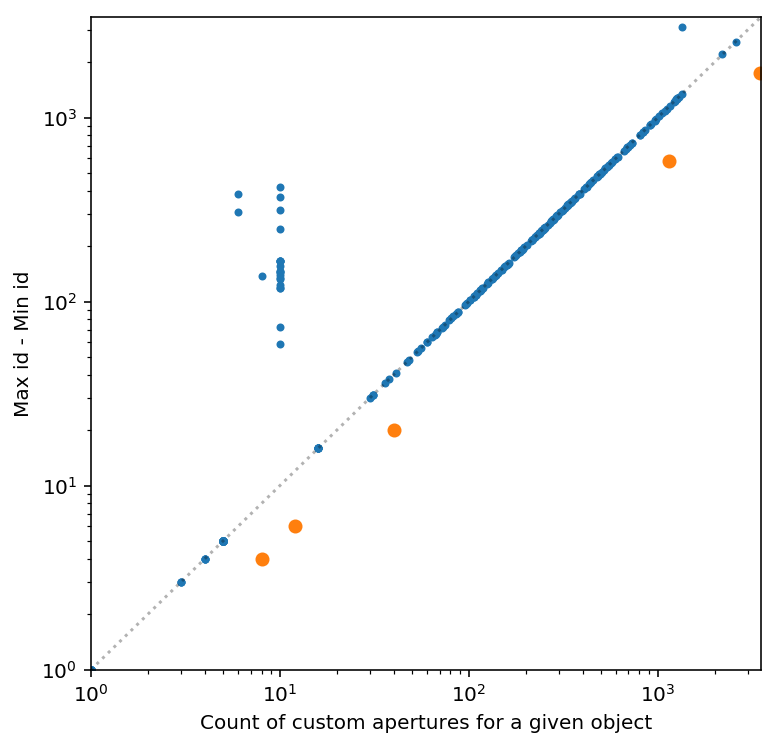

In [69]:
plt.figure(figsize=(6,6))
plt.plot(out3['count'], out3['diff'], '.')
plt.xscale('log')
plt.yscale('log')
plt.plot([1,3500], [1, 3500], 'k:', alpha=0.3)
plt.xlim(1, 3500)
plt.ylim(1, 3500)
plt.xlabel('Count of custom apertures for a given object')
plt.ylabel('Max id - Min id')

repeat_ids = out3['count'] > out3['diff']
plt.plot(out3['count'][repeat_ids], out3['diff'][repeat_ids], 'o')

Numbers below the line have more actual custom id counts than the difference between their maximum and minimum custom id number, suggesting some repeats.

In [70]:
out3[repeat_ids]

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN,"[91, 92]"
20,TNO.Quaoar,1154,200068780,200069356,577,NaN,"[91, 92]"
313,M8 Lagoon Nebula,40,200071160,200071179,20,NaN,"[91, 92]"
328,Dark Clouds,12,200069381,200069386,6,NaN,"[91, 92]"
351,Isolated Stars,8,200069387,200069390,4,NaN,"[91, 92]"


So for example in the last column:

In [71]:
200069390 - 200069387

3

Is less than the total count of "8".

In [72]:
caf_all[caf_all.object_name == 'Isolated Stars']

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
38071,200069387,4,NaN,NaN,NaN,Isolated Stars,92
38072,200069388,4,NaN,NaN,NaN,Isolated Stars,92
38073,200069389,4,NaN,NaN,NaN,Isolated Stars,92
38074,200069390,4,NaN,NaN,NaN,Isolated Stars,92
40809,200069387,4,NaN,NaN,NaN,Isolated Stars,91
40810,200069388,4,NaN,NaN,NaN,Isolated Stars,91
40811,200069389,4,NaN,NaN,NaN,Isolated Stars,91
40812,200069390,4,NaN,NaN,NaN,Isolated Stars,91


No big deal... It looks like all of these are in two halves of campaign 9, doubling their count. 

In [73]:
out3[repeat_ids]['diff'] * 2.0

0      3496.0
20     1154.0
313      40.0
328      12.0
351       8.0
Name: diff, dtype: float64

Solves that problem!

<!--NAVIGATION-->
< [K2 target index](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [Everest lightcurve metadata](01.06-Everest-lightcurve-metadata.ipynb) >